In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 4. ML models evaluation

The researchers working on the ACRIMA data prediction model also included their models along with the dataset[$^{[5]}$](https://biomedical-engineering-online.biomedcentral.com/articles/10.1186/s12938-019-0649-y#Sec9). Therefore, we'll try to use their models on the Kaggle dataset and see how they're performing compared to the simple CNN model trained on the same dataset in the previous notebook.

Each model is saved in a JSON file, with the algorithm weights being saved in a h5 file (Hierarchical Data Format). The files can be found [here](https://drive.google.com/drive/folders/133uwNfPLYQs2fyfmAfpWQXH4Zggkb3aF?usp=sharing).

Initially, the predictions were done using the just the `model.predict` method. However, since the complex models accuracy was extremely low using the unaltered dataset, the `ImageDataGenerator` was also employed on the testing dataset, thus improving accuracy significantly.

In [64]:
import os
import numpy as np
from utils import get_testing_data, load_acrima_model, draw_conf_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
kaggle_dir = "drive/MyDrive/glaucoma_detection/kaggle_dataset_cropped"
kaggle_g_dir = os.path.join(kaggle_dir, "glaucoma")
kaggle_n_dir = os.path.join(kaggle_dir, "normal")
models_dir = "drive/MyDrive/glaucoma_detection/pre_trained_models"

In [ ]:
X, y = get_testing_data([kaggle_g_dir, kaggle_n_dir], (229, 229))

In [80]:
# Adapt the classification model from the glaucoma assessment paper
def classify(model, test_data_dir, batch_size=8):
  
  if model.layers[0].input_shape[0] == None:
    input_shape = model.layers[0].input_shape[1:3]
  else:
    input_shape = model.layers[0].input_shape[0][1:3]
  
  # Read & augment data
  test_datagen = ImageDataGenerator(rescale=1. / 255)
  test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=False)
  # Calculate class posteriors probabilities
  y_probabilities = model.predict_generator(test_generator,
                                            steps = np.math.ceil(test_generator.samples / float(test_generator.batch_size))
                                            )
  return y_probabilities

#### 4.1. InceptionV3

In [8]:
inception_model = load_acrima_model("InceptionV3", models_dir)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 149, 149, 32  96         ['conv2d_1[0][0]']               
 rmalization)                   )                                                           

We notice that the model already has a final dense layer for classification, so no more layers need to be added.

In [70]:
y_pred = classify(inception_model, kaggle_dir)
print(y_pred[:10])

Found 401 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


[[0.99231577 0.00768422]
 [0.17894487 0.8210552 ]
 [0.9843109  0.01568899]
 [0.9848658  0.01513426]
 [0.9647312  0.03526884]
 [0.9748396  0.02516037]
 [0.8224268  0.17757317]
 [0.9851879  0.01481214]
 [0.9981092  0.00189073]
 [0.7317184  0.2682816 ]]


The models output two columns as opposed to one, noting the probability that the patient has glaucoma (column 1) or not (column 2). Therefore, we need to convert the predictions to a binary classification based on the higher probability class.

In [71]:
def convert_predictions(predictions_array):
  new_predictions = []
  for row in predictions_array:
    if row[0] > row[1]:
      new_predictions.append(0)
    else:
      new_predictions.append(1)
  
  new_predictions = np.array(new_predictions)
  return new_predictions

In [72]:
y_pred_conv = convert_predictions(y_pred)
y_pred_conv.shape

(401,)

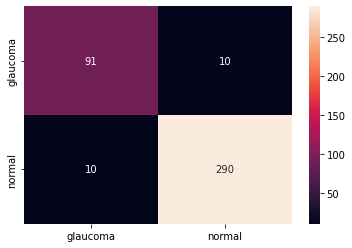

Glaucoma prediction accuracy: 90.1 %
Normal prediction accuracy: 96.67 %


In [73]:
draw_conf_matrix(y, y_pred_conv)

#### 4.2. ResNet50

In [27]:
resnet_model = load_acrima_model("ResNet50", models_dir)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_1[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_1[0][0]']       
                                )                                                           

In [75]:
y_pred = classify(resnet_model, kaggle_dir)
print(y_pred[:10])

Found 401 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


[[0.99815124 0.00184873]
 [0.09976136 0.90023863]
 [0.47667518 0.5233247 ]
 [0.9987116  0.00128848]
 [0.8608961  0.1391039 ]
 [0.98543316 0.01456687]
 [0.9859483  0.01405173]
 [0.9952857  0.0047143 ]
 [0.9954965  0.00450351]
 [0.51495135 0.48504865]]


In [82]:
y_pred_conv = convert_predictions(y_pred)
y_pred_conv.shape

(401,)

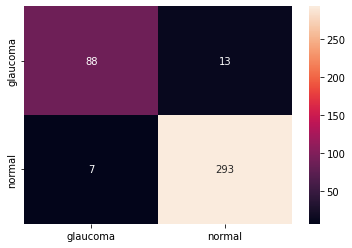

Glaucoma prediction accuracy: 87.13 %
Normal prediction accuracy: 97.67 %


In [83]:
draw_conf_matrix(y, y_pred_conv)

#### 4.3. VGG16

In [84]:
vgg16_model = load_acrima_model("VGG16", models_dir)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [85]:
y_pred = classify(vgg16_model, kaggle_dir)
print(y_pred[:10])

Found 401 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


[[7.8052485e-01 2.1947517e-01]
 [3.3492982e-01 6.6507012e-01]
 [8.2266957e-01 1.7733039e-01]
 [9.9514019e-01 4.8598154e-03]
 [9.9594647e-01 4.0535717e-03]
 [9.9950206e-01 4.9794652e-04]
 [9.4513470e-01 5.4865357e-02]
 [9.9831653e-01 1.6835100e-03]
 [9.6381861e-01 3.6181401e-02]
 [8.8037366e-01 1.1962636e-01]]


In [86]:
y_pred_conv = convert_predictions(y_pred)
y_pred_conv.shape

(401,)

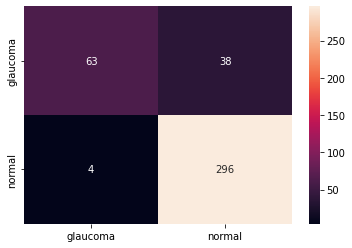

Glaucoma prediction accuracy: 62.38 %
Normal prediction accuracy: 98.67 %


In [87]:
draw_conf_matrix(y, y_pred_conv)

#### 4.4. VGG19

In [41]:
vgg19_model = load_acrima_model("VGG19", models_dir)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [88]:
y_pred = classify(vgg19_model, kaggle_dir)
print(y_pred[:10])

Found 401 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


[[8.7422121e-01 1.2577878e-01]
 [9.9609214e-01 3.9078416e-03]
 [8.0815166e-01 1.9184831e-01]
 [9.9999690e-01 3.0688216e-06]
 [9.9999285e-01 7.1117574e-06]
 [9.9999976e-01 2.5233678e-07]
 [9.9991691e-01 8.3077168e-05]
 [9.9997234e-01 2.7665192e-05]
 [9.9719512e-01 2.8048693e-03]
 [9.6419972e-01 3.5800260e-02]]


In [89]:
y_pred_conv = convert_predictions(y_pred)
y_pred_conv.shape

(401,)

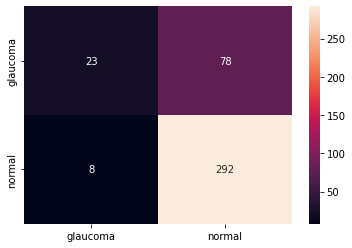

Glaucoma prediction accuracy: 22.77 %
Normal prediction accuracy: 97.33 %


In [45]:
draw_conf_matrix(y, y_pred_conv)

#### 4.5. Xception

In [46]:
xception_model = load_acrima_model("Xception", models_dir)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [90]:
y_pred = classify(xception_model, kaggle_dir)
print(y_pred[:10])

Found 401 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


[[0.8479531  0.1520469 ]
 [0.16499448 0.8350055 ]
 [0.48707333 0.5129267 ]
 [0.74413085 0.25586915]
 [0.97268176 0.02731826]
 [0.9870193  0.01298073]
 [0.9877264  0.01227367]
 [0.70434165 0.29565838]
 [0.9168404  0.0831596 ]
 [0.9311984  0.06880154]]


In [91]:
y_pred_conv = convert_predictions(y_pred)
y_pred_conv.shape

(401,)

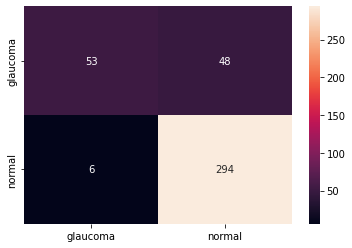

Glaucoma prediction accuracy: 52.48 %
Normal prediction accuracy: 98.0 %


In [92]:
draw_conf_matrix(y, y_pred_conv)

#### 4.6. Simple model

In [13]:
simple_model = load_acrima_model("simple_model", models_dir)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 118336)            0         
                                                                 
 dense (Dense)               (None, 512)               6

In [93]:
y_pred = classify(simple_model, kaggle_dir)
print(y_pred[:10])

Found 401 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


[[1.3141036e-03]
 [1.4182925e-04]
 [2.9723700e-05]
 [5.8133066e-01]
 [3.5293400e-03]
 [6.2155724e-04]
 [5.4320693e-01]
 [5.4559112e-04]
 [2.0851618e-05]
 [5.1844887e-05]]


In [94]:
# Convert probabilities to glaucoma / normal prediction
y_pred_conv = []

for probability in y_pred:
  if probability > 0.5:
    y_pred_conv.append(1)
  else:
    y_pred_conv.append(0)

y_pred_conv = np.array(y_pred_conv)
y_pred_conv.shape

(401,)

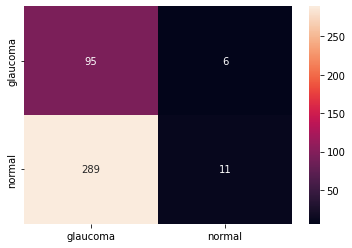

Glaucoma prediction accuracy: 94.06 %
Normal prediction accuracy: 3.67 %


In [96]:
draw_conf_matrix(y, y_pred_conv)

In [79]:
simple_model.layers[0].input_shape[1:3]

(178, 178)

### 5. Conclusion 

We can see that our model does not generalize well even when the images in the Kaggle dataset have been cropped. This suggests any of the following:
<ol>
<li> the training dataset was too small, even when we generated modified images </li>
<li> the model oversimplifies the pictures and therefore has a high bias on testing data </li>
<li> the U-Net used to crop the images did not accurately detect the optical disc in the Kaggle dataset </li>
</ol>

We will eliminate point #3 given that the other neural networks had a significantly higher performance when used on the cropped testing dataset.

### 6. Next steps

Given the difference in performance between the simple and more complex detection architectures, next steps to improve our performance would be:
<ol>
<li> training the architectures presented above on the ACRIMA dataset to check if point #1 is the main driver of the difference </li>
<li> training the simple model on more datasets to check if point #2 is the main driver for the difference </li>
</ol>

### 7. References

Listed in the [`README.md`](https://github.com/sabinagio/do-you-see-what-AI-see) in the main directory of this repository.